In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=596b649f37f3c2d1c59379e4c50dbcb91eb92283db7b33df53ba96b1f5e4b5de
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml import Pipeline
import re
from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [4]:
# Initialize a Spark session
spark = SparkSession.builder.appName("TwitterSentimentAnalysis").master('local[*]').getOrCreate()


In [5]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("branch", StringType(), True),
    StructField("sentiment", StringType(), True),
    StructField("tweet", StringType(), True)
])

training = spark.read.csv("twitter_training.csv", header=True, schema=schema)
validation = spark.read.csv("twitter_validation.csv", header=True, schema=schema)


In [6]:
training.printSchema()
validation.printSchema()

root
 |-- id: integer (nullable = true)
 |-- branch: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- tweet: string (nullable = true)

root
 |-- id: integer (nullable = true)
 |-- branch: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- tweet: string (nullable = true)



In [7]:
training.show()

+----+-----------+---------+--------------------+
|  id|     branch|sentiment|               tweet|
+----+-----------+---------+--------------------+
|2401|Borderlands| Positive|I am coming to th...|
|2401|Borderlands| Positive|im getting on bor...|
|2401|Borderlands| Positive|im coming on bord...|
|2401|Borderlands| Positive|im getting on bor...|
|2401|Borderlands| Positive|im getting into b...|
|2402|Borderlands| Positive|So I spent a few ...|
|2402|Borderlands| Positive|So I spent a coup...|
|2402|Borderlands| Positive|So I spent a few ...|
|2402|Borderlands| Positive|So I spent a few ...|
|2402|Borderlands| Positive|2010 So I spent a...|
|2402|Borderlands| Positive|                 was|
|2403|Borderlands|  Neutral|Rock-Hard La Varl...|
|2403|Borderlands|  Neutral|Rock-Hard La Varl...|
|2403|Borderlands|  Neutral|Rock-Hard La Varl...|
|2403|Borderlands|  Neutral|Rock-Hard La Vita...|
|2403|Borderlands|  Neutral|Live Rock - Hard ...|
|2403|Borderlands|  Neutral|I-Hard like me, R...|


In [8]:
validation.show()

+-----+--------------------+---------+--------------------+
|   id|              branch|sentiment|               tweet|
+-----+--------------------+---------+--------------------+
|  352|              Amazon|  Neutral|BBC News - Amazon...|
| 8312|           Microsoft| Negative|@Microsoft Why do...|
| 4371|               CS-GO| Negative|CSGO matchmaking ...|
| 4433|              Google|  Neutral|Now the President...|
| 6273|                FIFA| Negative|Hi @EAHelp I’ve h...|
| 7925|           MaddenNFL| Positive|Thank you @EAMadd...|
| NULL|                NULL|     NULL|                NULL|
| NULL|                NULL|     NULL|                NULL|
| NULL|                NULL|     NULL|                NULL|
|11332|TomClancysRainbowSix| Positive|Rocket League, Se...|
| 1107|      AssassinsCreed| Positive|my ass still knee...|
| 2069|          CallOfDuty| Negative|FIX IT JESUS ! Pl...|
| 3185|               Dota2| Positive|The professional ...|
| NULL|                NULL|     NULL|  

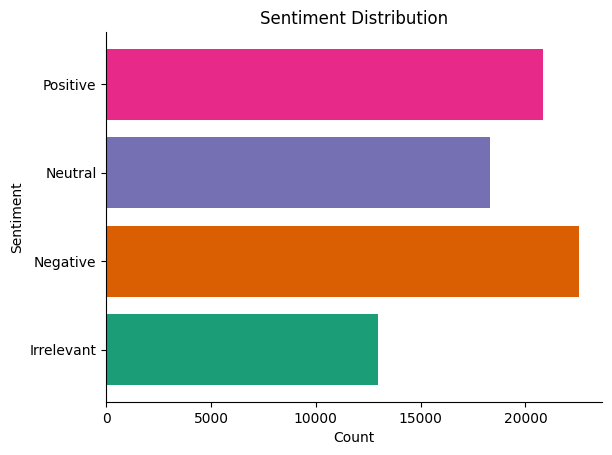

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group data by sentiment and count the occurrences
sentiment_counts = training.groupBy('sentiment').count().orderBy('sentiment')

# Collect data to the driver
sentiment_counts_collect = sentiment_counts.collect()

# Extract sentiment labels and counts
sentiments = [row['sentiment'] for row in sentiment_counts_collect]
counts = [row['count'] for row in sentiment_counts_collect]

# Plotting
plt.barh(sentiments, counts, color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Count')
plt.ylabel('Sentiment')
plt.title('Sentiment Distribution')
plt.show()


In [10]:
from pyspark.sql.functions import sum, col

# Count null values in each column
missing_values1 = training.agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in training.columns])

# Show the result
missing_values1.show()


+---+------+---------+-----+
| id|branch|sentiment|tweet|
+---+------+---------+-----+
|  0|     0|        0|  686|
+---+------+---------+-----+



In [11]:
# Drop rows with any null values
training = training.na.drop()

# Show the updated DataFrame
training.show()


+----+-----------+---------+--------------------+
|  id|     branch|sentiment|               tweet|
+----+-----------+---------+--------------------+
|2401|Borderlands| Positive|I am coming to th...|
|2401|Borderlands| Positive|im getting on bor...|
|2401|Borderlands| Positive|im coming on bord...|
|2401|Borderlands| Positive|im getting on bor...|
|2401|Borderlands| Positive|im getting into b...|
|2402|Borderlands| Positive|So I spent a few ...|
|2402|Borderlands| Positive|So I spent a coup...|
|2402|Borderlands| Positive|So I spent a few ...|
|2402|Borderlands| Positive|So I spent a few ...|
|2402|Borderlands| Positive|2010 So I spent a...|
|2402|Borderlands| Positive|                 was|
|2403|Borderlands|  Neutral|Rock-Hard La Varl...|
|2403|Borderlands|  Neutral|Rock-Hard La Varl...|
|2403|Borderlands|  Neutral|Rock-Hard La Varl...|
|2403|Borderlands|  Neutral|Rock-Hard La Vita...|
|2403|Borderlands|  Neutral|Live Rock - Hard ...|
|2403|Borderlands|  Neutral|I-Hard like me, R...|


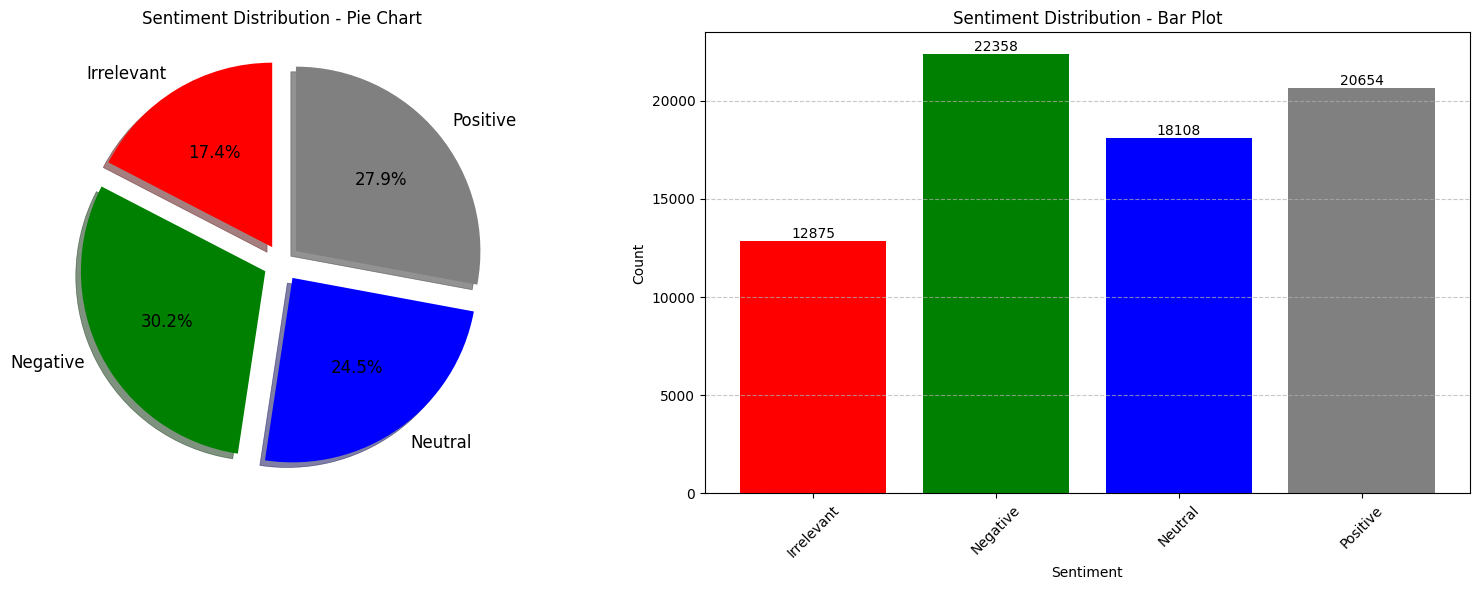

In [12]:
import matplotlib.pyplot as plt

# Calculate sentiment distribution
sentiment_distribution = training.groupBy('sentiment').count().orderBy('sentiment').toPandas()

# Define colors
colors = ['red', 'green', 'blue', 'gray']

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plotting pie chart for sentiment distribution with custom colors
axs[0].pie(sentiment_distribution['count'], labels=sentiment_distribution['sentiment'], autopct='%1.1f%%',
            startangle=90, wedgeprops={'linewidth': 0.5}, textprops={'fontsize': 12},
            explode=[0.1, 0.1, 0.1, 0.1], colors=colors, shadow=True)
axs[0].set_title('Sentiment Distribution - Pie Chart')

# Plotting bar plot for sentiment distribution
axs[1].bar(sentiment_distribution['sentiment'], sentiment_distribution['count'], color=colors)
axs[1].set_title('Sentiment Distribution - Bar Plot')
axs[1].set_xlabel('Sentiment')
axs[1].set_ylabel('Count')
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)
# Add text on top of each bar in the bar plot
for i, count in enumerate(sentiment_distribution['count']):
    axs[1].text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [13]:
# Filter out rows with non-string values in the specified column
def filter_non_string(df, column):
    df = df.filter(df[column].isNotNull())
    df = df.withColumn(column, df[column].cast(StringType()))
    return df

In [14]:
# Convert text to lowercase
def normalize_text(text):
    return text.lower()

In [15]:
# Remove HTML tags from the text
def remove_html_tags(text):
    return re.sub(r'<.*?>', '', text)

In [16]:
# Remove URLs or hyperlinks from the text
def remove_urls(text):
    return re.sub(r'http\S+|www\S+', '', text)

In [17]:
# Exclude numerical digits from the text
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

In [18]:
# Remove punctuation marks from the text
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

In [19]:
# Remove emojis from the text
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


In [20]:
# Define UDFs for preprocessing steps
normalize_text_udf = udf(normalize_text, StringType())
remove_html_tags_udf = udf(remove_html_tags, StringType())
remove_urls_udf = udf(remove_urls, StringType())
remove_numbers_udf = udf(remove_numbers, StringType())
remove_punctuation_udf = udf(remove_punctuation, StringType())
remove_emojis_udf = udf(remove_emojis, StringType())

# Preprocess text
def preprocess_text(df, column):
    df = filter_non_string(df, column)
    df = df.withColumn(column, normalize_text_udf(col(column)))
    df = df.withColumn(column, remove_html_tags_udf(col(column)))
    df = df.withColumn(column, remove_urls_udf(col(column)))
    df = df.withColumn(column, remove_numbers_udf(col(column)))
    df = df.withColumn(column, remove_punctuation_udf(col(column)))
    df = df.withColumn(column, remove_emojis_udf(col(column)))
    return df

# Usage:
training_processed = preprocess_text(training, 'tweet')

In [21]:
# Tokenize text
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered")

# Apply HashingTF and IDF to generate TF-IDF vectors
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Build the pipeline
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf])

# Fit and transform the data
model = pipeline.fit(training_processed)
training_processed = model.transform(training_processed)

training_processed.show()

+----+-----------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  id|     branch|sentiment|               tweet|               words|            filtered|         rawFeatures|            features|
+----+-----------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+
|2401|Borderlands| Positive|i am coming to th...|[i, am, coming, t...|[coming, borders,...|(262144,[12409,14...|(262144,[12409,14...|
|2401|Borderlands| Positive|im getting on bor...|[im, getting, on,...|[im, getting, bor...|(262144,[31015,23...|(262144,[31015,23...|
|2401|Borderlands| Positive|im coming on bord...|[im, coming, on, ...|[im, coming, bord...|(262144,[12409,31...|(262144,[12409,31...|
|2401|Borderlands| Positive|im getting on bor...|[im, getting, on,...|[im, getting, bor...|(262144,[31015,92...|(262144,[31015,92...|
|2401|Borderlands| Positive|im getting into b...|[im, getting,

In [22]:
from pyspark.sql.types import StringType, ArrayType
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType, ArrayType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml import Pipeline
import re

# Convert list of words into a single string for each entry in 'tweet' column
join_words_udf = udf(lambda words: ' '.join(words), StringType())
df_processed = training_processed.withColumn('tweet', join_words_udf(col('filtered')))


# StringIndexer encodes a string column of labels to a column of label indices
indexer = StringIndexer(inputCol="sentiment", outputCol="label")

# Build the pipeline
pipeline = Pipeline(stages=[indexer])

# Fit and transform the data
df_processed = pipeline.fit(df_processed).transform(df_processed)

# Split data into training and testing sets (80% training, 20% testing)
train, test = df_processed.randomSplit([0.8, 0.2], seed=42)

# Print the shapes of the training and testing sets
print("Shape of train:", (train.count(), len(train.columns)))
print("Shape of test:", (test.count(), len(test.columns)))

Shape of train: (59215, 9)
Shape of test: (14780, 9)


In [ ]:
from pyspark.ml.classification import LogisticRegression

# Assume df_final is preprocessed DataFrame with features and label
lr = LogisticRegression(featuresCol='features', labelCol='label')
lrModel = lr.fit(df_processed)
predictions = lrModel.transform(df_processed)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Logistic Regression Accuracy: %f" % accuracy)


In [40]:
# Save the model
lrModel.save("lrmodel")


In [44]:
# Load the saved model
from pyspark.ml.classification import LogisticRegressionModel
loaded_lr_model = LogisticRegressionModel.load("lrmodel")

# Preprocess the validation data
validation_processed = preprocess_text(validation, 'tweet')
validation_processed = model.transform(validation_processed)

# Convert list of words into a single string for each entry in 'tweet' column
validation_processed = validation_processed.withColumn('tweet', join_words_udf(col('filtered')))

# Transform the validation data
validation_processed = pipeline.fit(validation_processed).transform(validation_processed)

# Classify the validation data
predictions = loaded_lr_model.transform(validation_processed)

# Convert numerical labels back to sentiment words
label_converter = IndexToString(inputCol="prediction", outputCol="predicted_sentiment", labels=['negative', 'neutral', 'positive', 'very positive'])

# Apply the label converter to the predictions
predictions = label_converter.transform(predictions)

# Select relevant columns for display
predictions.select("tweet", "sentiment", "predicted_sentiment").show(truncate=True)


Py4JJavaError: An error occurred while calling o3049.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 326.0 failed 1 times, most recent failure: Lost task 0.0 in stage 326.0 (TID 532) (81b70617a65b executor driver): org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`IndexToString$$Lambda$5074/0x0000000841404840`: (double) => string).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Unseen index: 3.0 ??
	at org.apache.spark.ml.feature.IndexToString.$anonfun$transform$5(StringIndexer.scala:615)
	at org.apache.spark.ml.feature.IndexToString.$anonfun$transform$5$adapted(StringIndexer.scala:610)
	... 20 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:530)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:483)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:61)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4332)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:3314)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4322)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4320)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4320)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:3314)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3537)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:280)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:315)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`IndexToString$$Lambda$5074/0x0000000841404840`: (double) => string).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: org.apache.spark.SparkException: Unseen index: 3.0 ??
	at org.apache.spark.ml.feature.IndexToString.$anonfun$transform$5(StringIndexer.scala:615)
	at org.apache.spark.ml.feature.IndexToString.$anonfun$transform$5$adapted(StringIndexer.scala:610)
	... 20 more


In [ ]:
import numpy as np
import xgboost as xgb
# Convert Spark DataFrame to NumPy array
train_features = np.array(train.select('features').collect())
train_labels = np.array(train.select('label').collect())
test_features = np.array(test.select('features').collect())
test_labels = np.array(test.select('label').collect())

# Convert NumPy arrays to DMatrix
dtrain = xgb.DMatrix(train_features, label=train_labels)
dtest = xgb.DMatrix(test_features, label=test_labels)

# Set parameters for XGBoost
params = {
    'objective': 'multi:softmax',  # Multiclass classification
    'num_class': len(df_processed.select('label').distinct().collect()),  # Number of classes
    'eval_metric': 'merror'  # Evaluation metric
}

# Train XGBoost model
num_round = 100
xgb_model = xgb.train(params, dtrain, num_round)

# Make predictions on the test set
preds = xgb_model.predict(dtest)

# Evaluate the model
accuracy_xgb = sum(preds == test.select('label').rdd.map(lambda x: x.label).collect()) / len(preds)
print("XGBoost Accuracy:", accuracy_xgb)


In [45]:
from pyspark.ml.classification import RandomForestClassifier

# Initialize Random Forest Classifier
rf = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=100)

# Train the model
rf_model = rf.fit(train)

# Make predictions on the test set
predictions_rf = rf_model.transform(test)

# Evaluate the Random Forest model
accuracy_rf = evaluator.evaluate(predictions_rf)
print("Random Forest Accuracy:", accuracy_rf)


Py4JJavaError: An error occurred while calling o3053.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 331.0 failed 1 times, most recent failure: Lost task 0.0 in stage 331.0 (TID 540) (81b70617a65b executor driver): java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.ml.tree.impl.TreePoint$.labeledPointToTreePoint(TreePoint.scala:91)
	at org.apache.spark.ml.tree.impl.TreePoint$.$anonfun$convertToTreeRDD$4(TreePoint.scala:75)
	at org.apache.spark.ml.tree.impl.TreePoint$$$Lambda$5215/0x0000000841caf040.apply(Unknown Source)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at org.apache.spark.storage.memory.PartiallyUnrolledIterator.next(MemoryStore.scala:785)
	at org.apache.spark.serializer.SerializationStream.writeAll(Serializer.scala:140)
	at org.apache.spark.serializer.SerializerManager.dataSerializeStream(SerializerManager.scala:177)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$3(BlockManager.scala:1606)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$3$adapted(BlockManager.scala:1604)
	at org.apache.spark.storage.BlockManager$$Lambda$5229/0x0000000841a03840.apply(Unknown Source)
	at org.apache.spark.storage.DiskStore.put(DiskStore.scala:88)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1604)
	at org.apache.spark.storage.BlockManager$$Lambda$2108/0x0000000840e7a040.apply(Unknown Source)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1524)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1588)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1389)
	at org.apache.spark.storage.BlockManager.getOrElseUpdateRDDBlock(BlockManager.scala:1343)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:379)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.executor.Executor$TaskRunner$$Lambda$2515/0x0000000840fe4840.apply(Unknown Source)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$collectAsMap$1(PairRDDFunctions.scala:738)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:737)
	at org.apache.spark.ml.tree.impl.RandomForest$.findBestSplits(RandomForest.scala:663)
	at org.apache.spark.ml.tree.impl.RandomForest$.runBagged(RandomForest.scala:208)
	at org.apache.spark.ml.tree.impl.RandomForest$.run(RandomForest.scala:302)
	at org.apache.spark.ml.classification.RandomForestClassifier.$anonfun$train$1(RandomForestClassifier.scala:168)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.RandomForestClassifier.train(RandomForestClassifier.scala:139)
	at org.apache.spark.ml.classification.RandomForestClassifier.train(RandomForestClassifier.scala:47)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.ml.tree.impl.TreePoint$.labeledPointToTreePoint(TreePoint.scala:91)
	at org.apache.spark.ml.tree.impl.TreePoint$.$anonfun$convertToTreeRDD$4(TreePoint.scala:75)
	at org.apache.spark.ml.tree.impl.TreePoint$$$Lambda$5215/0x0000000841caf040.apply(Unknown Source)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at org.apache.spark.storage.memory.PartiallyUnrolledIterator.next(MemoryStore.scala:785)
	at org.apache.spark.serializer.SerializationStream.writeAll(Serializer.scala:140)
	at org.apache.spark.serializer.SerializerManager.dataSerializeStream(SerializerManager.scala:177)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$3(BlockManager.scala:1606)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$3$adapted(BlockManager.scala:1604)
	at org.apache.spark.storage.BlockManager$$Lambda$5229/0x0000000841a03840.apply(Unknown Source)
	at org.apache.spark.storage.DiskStore.put(DiskStore.scala:88)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1604)
	at org.apache.spark.storage.BlockManager$$Lambda$2108/0x0000000840e7a040.apply(Unknown Source)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1524)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1588)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1389)
	at org.apache.spark.storage.BlockManager.getOrElseUpdateRDDBlock(BlockManager.scala:1343)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:379)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.executor.Executor$TaskRunner$$Lambda$2515/0x0000000840fe4840.apply(Unknown Source)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)


In [29]:
import pickle

try:
    # Load the saved model
    with open('lrModel.pkl', 'rb') as f:
        loaded_model = pickle.load(f)
except EOFError:
    print("Error: Encountered EOFError while loading the model.")
    print("The pickle file may be incomplete or corrupted.")


Error: Encountered EOFError while loading the model.
The pickle file may be incomplete or corrupted.
